# Prompt Engineering

The aim in this project is to explore the distances between embeddings of prompts to understand how language models (LMs) behave when presented with different input stimuli. The goal is to uncover patterns in LM response generation and representation learning by observing how distinct embeddings are generated for prompts conveying identical contextual meanings. By analyzing these embedding distances, there is a chance to uncover the underlying mechanisms shaping LM behavior and derive insights to enhance model performance through prompt engineering across different tasks and domains.

Here, we consider the angles between the eigenvectors of different prompt pairs modified according to various contexts. Here are the types of token pairs that were considered:

- **Synonymous Tokens:** Pairing tokens with similar meanings but different lexical forms, such as "big" and "large," to assess the LM's sensitivity to synonyms.
    
- **Antonymous Tokens:** Pairing tokens with opposite meanings, such as "hot" and "cold," to evaluate the LM's ability to distinguish between contrasting concepts.
    
- **Hyponym-Hypernym Tokens:** Pairing tokens representing a hierarchical relationship, such as "dog" and "animal," to examine the LM's understanding of broader and narrower semantic categories.
    
- **Temporal Tokens:** Pairing tokens representing different time frames, such as "past" and "future," to investigate how the LM encodes temporal relationships and context.
    
- **Geographical Tokens:** Pairing tokens associated with different locations or regions, such as "Paris" and "New York," to evaluate the LM's understanding of spatial relationships and geographic context.
    
- **Sentiment Tokens:** Pairing tokens with contrasting sentiment polarities, such as "happy" and "sad," to assess the LM's ability to capture emotional nuances and sentiment analysis.

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from transformer_lens import HookedTransformer
# from jaxtyping import Float, Int
from muutils.dictmagic import condense_tensor_dict

In [56]:
def read_jsonl(fname: str) -> list:
    # read a jsonl file into a list of prompts
    with open(fname, 'r') as f:
        return [json.loads(line) for line in f]
    
def angle_between(u, u1, index=0):
    # calculate the cosine similarity between the eigenvectors
    # get angle between two vectors
    return np.arccos(np.dot(u[:,0], u1[:,0])/(np.linalg.norm(u[:,0])*np.linalg.norm(u1[:,0])))

def compare_prompts_eig(
    prompts: list[tuple[str, str]],
    model: HookedTransformer,
    eigvec_dist = "norm",
    index = 0,
):
    # compare the eigenvectors of two prompts at each layer
    n_layers: int = model.cfg.n_layers
    all_angles = []

    for pair in prompts:
        angles = []
        for a in range(n_layers):
            block = f"blocks.{a}.hook_resid_post"
            embeds = model.run_with_cache(pair)[1][block].cpu().detach().numpy()

            u, _, _ = np.linalg.svd(embeds[0].T, full_matrices=False)
            u1, _, _ = np.linalg.svd(embeds[1].T, full_matrices=False)

            angles.append(angle_between(u, u1, index))

        # all_angles.extend(angles)
        all_angles.append(angles)
        xx = np.arange(n_layers) + np.random.normal(0, 0.1, n_layers)
        plt.plot(xx, angles, 'o', alpha=0.1, color='blue')

    all_angles = np.array(all_angles)
    sns.boxplot(data=all_angles, color=".8", linewidth=2)  # Add swarmplot for individual points
    plt.ylabel('Angle Between Eigenvectors', fontsize=12)
    plt.xlabel('Layer', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale("log")
    # plt.title('Distribution of angles between first eigenvectors')
    plt.grid(True)

Load pre-trained language models.

In [27]:
MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
# MODEL: HookedTransformer = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model tiny-stories-3M into HookedTransformer


## Antonyms

Pairing tokens with opposite meanings, such as "hot" and "cold," to evaluate the LM's ability to distinguish between contrasting concepts.

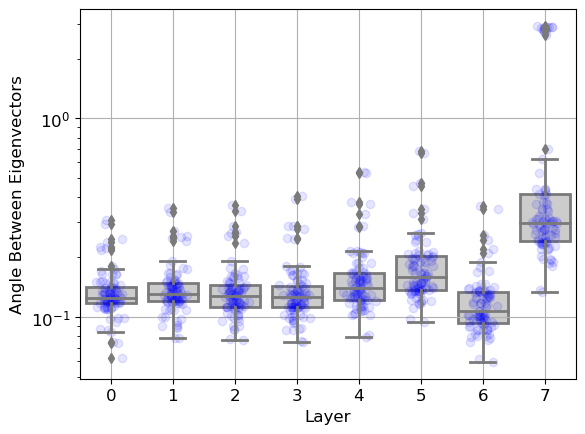

In [60]:
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# compare_prompts_eig(
#     read_jsonl("data/antonyms.jsonl"),
#     model=MODEL,
#     index=0,
# )
# plt.subplot(1, 2, 2)
compare_prompts_eig(
    read_jsonl("data/antonyms.jsonl"),
    model=MODEL,
    index=0,
)

## Synonyms

Pairing tokens with similar meanings but different lexical forms, such as "big" and "large," to assess the LM's sensitivity to synonyms.

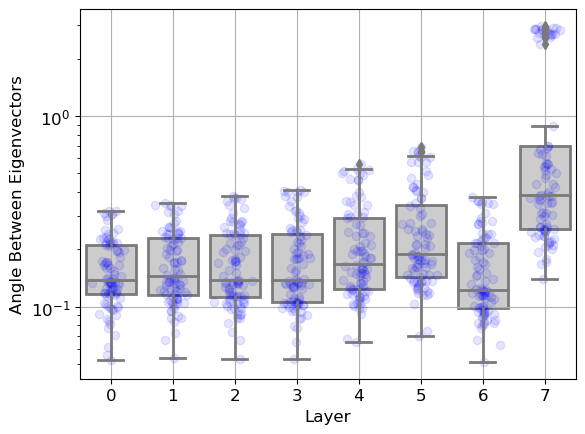

In [61]:
compare_prompts_eig(
    read_jsonl("data/synonyms.jsonl"),
    model=MODEL,
    index=0,
)

**Hyponym-Hypernym Tokens:**

Pairing tokens representing a hierarchical relationship, such as "dog" and "animal," to examine the LM's understanding of broader and narrower semantic categories.

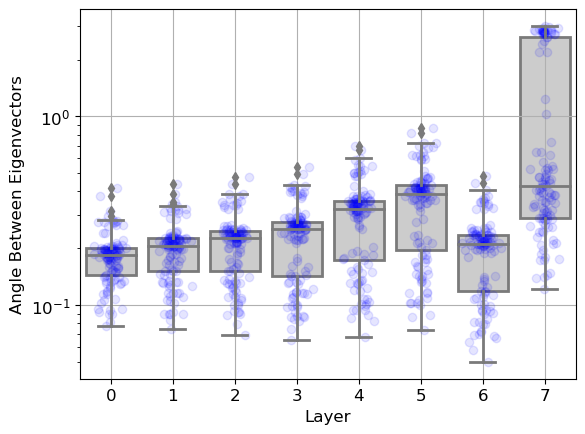

In [62]:
compare_prompts_eig(
    read_jsonl("data/hypernym_hyponym.jsonl"),
    model=MODEL,
)

**Temporal Tokens:**
Pairing tokens representing different time frames, such as "past" and "future," to investigate how the LM encodes temporal relationships and context.

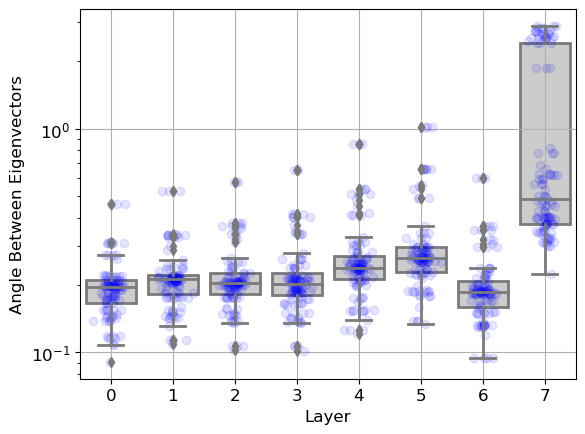

In [63]:
compare_prompts_eig(
    read_jsonl("data/temporal.jsonl"),
    model=MODEL,
)

**Sentiment Tokens:**
Pairing tokens with contrasting sentiment polarities, such as "happy" and "sad," to assess the LM's ability to capture emotional nuances and sentiment analysis

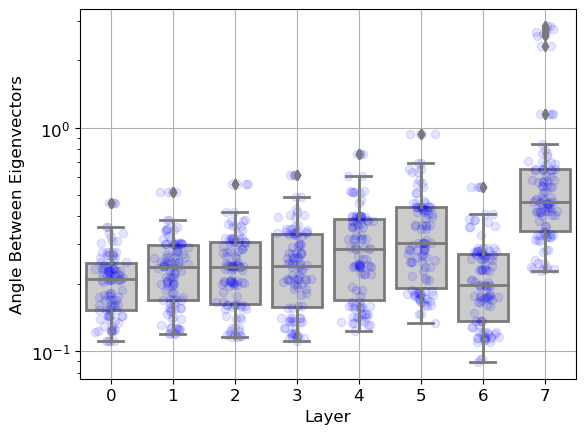

In [64]:
compare_prompts_eig(
    read_jsonl("data/sentiments.jsonl"),
    model=MODEL,
)

**Abstract-Concrete Tokens:**
Pairing tokens representing abstract concepts with tokens representing concrete objects or actions, such as "freedom" and "running," to explore the LM's capability to capture varying levels of concreteness.

**Geographical Tokens:**
Pairing tokens associated with different locations or regions, such as "Paris" and "New York," to evaluate the LM's understanding of spatial relationships and geographic context.

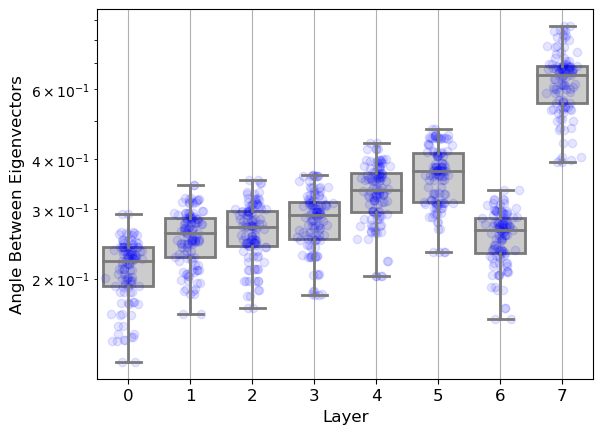

In [65]:
compare_prompts_eig(
    read_jsonl("data/locations.jsonl"),
    model=MODEL,
)

**Domain-specific Tokens:**
Pairing tokens from different domains, such as "neuron" and "molecule," to assess the LM's ability to handle specialized terminology and context.

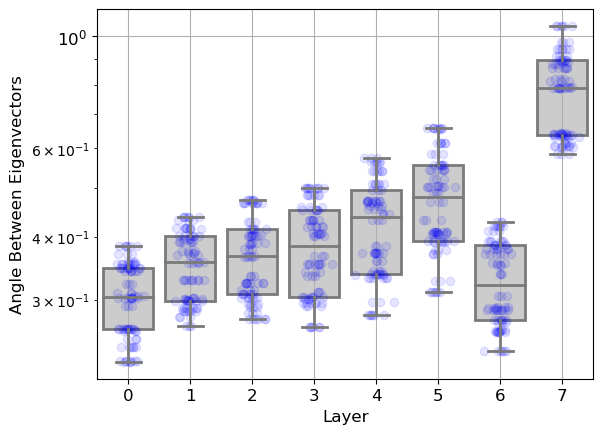

In [66]:
compare_prompts_eig(
    read_jsonl("data/domain.jsonl"),
    model=MODEL,
)